## <span style="color:green"><h1><center>DEM Accessing using a Shapefile</center></h1></span>
<center>Prepared by <br>
    <b>Jibin Joseph and Venkatesh Merwade</b><br> 
Lyles School of Civil Engineering, Purdue University<br>
joseph57@purdue.edu, vmerwade@purdue.edu<br>
<b><br>
    FAIR Science in Water Resources</b><br></center>


## <span style="color:green">Objective</span>
<p style='text-align: justify;'>We will download DEM raster files from USGS National Elevation Dataset using the extents of watershed shapefile accessed using USGS site number. Later, the DEM raster files will be plotted along with watershed boundary.</p> 

## <span style="color:green"> Data Source </span>

<p style='text-align: justify;'>USGS 1/3 arc second DEM</p>

## <span style="color:green">Overview of steps </span>
<ol type="1">
    <span style="color:red"><li>Using USGS Station Number, get the shapefile for a  basin (watershed) and it extents</li></span>
    <span style="color:red"><li>Download the DEM from USGS-Amazon Web Service</li></span>
     <span style="color:red"><li>Plotting the Unmerged Raster Tiles</li></span>



## <span style="color:green">Import the packages/modules required for this exercise</span>

We need different packages as shown below. It can be either installed using pip method or conda method.


In [7]:
## Import the modules/packages/libraries required
import math
import numpy as np
import os
import matplotlib.pyplot as plt

from pynhd import NLDI
import urllib.request
import progressbar
import rasterio
import rasterio.plot

## <span style="color:green">Step 1a: Input USGS Site, DEM resolution, and create a directory</span> 
<ul>
<li>Input: <span style="color:red">USGS Site</span></li>
<li>Input: <span style="color:red">Desired resolution</span></li>
<li>Create: <span style="color:red">Folder for storing input raster files from USGS AWS</span></li>

In [8]:
## Input the USGS site number to get the shapefile
## E.g. "04180000" has a drainage area of 270 sq mi and can downloaded within 2-3 minutes
## But "03335500" has a drainage area of 7267 sq mi and needs for time and space
## WRITE CODE BELOW


## Resolution of required DEM
## USGS-AWS has different options like 1/3 arc second (code = 13), 1/9 arc second (code = 19; currently unavailable)
## WRITE CODE BELOW
  

## Define a function for making a directory depending on whether is exists or not.
## We are creating a function so that it can be used later for creating three folders in the later modules
def check_create_path_func(path):
    isExist = os.path.exists(path)
    if not isExist:
        # Create a new directory because it does not exist
        os.makedirs(path)
        print(f"The new directory \033[1m'{path}'\033[0m is created!")
    else:
        print(f"The new directory \033[1m'{path}'\033[0m is not created as it already exists!")
        
## Create the a folder for storing DEMs using the earlier defined function
## WRITE CODE BELOW



The new directory './input_04180000' is not created as it already exists!


## <span style="color:green">Step 1b: Input USGS Site and get the basin</span> 

<ul>
<li>Input: <span style="color:red">Get a input station</span></li>
<li>Output: <span style="color:red">Find out the basin</span></li>
<li>Output: <span style="color:red">Save the basin file as shapefile</span></li>
    

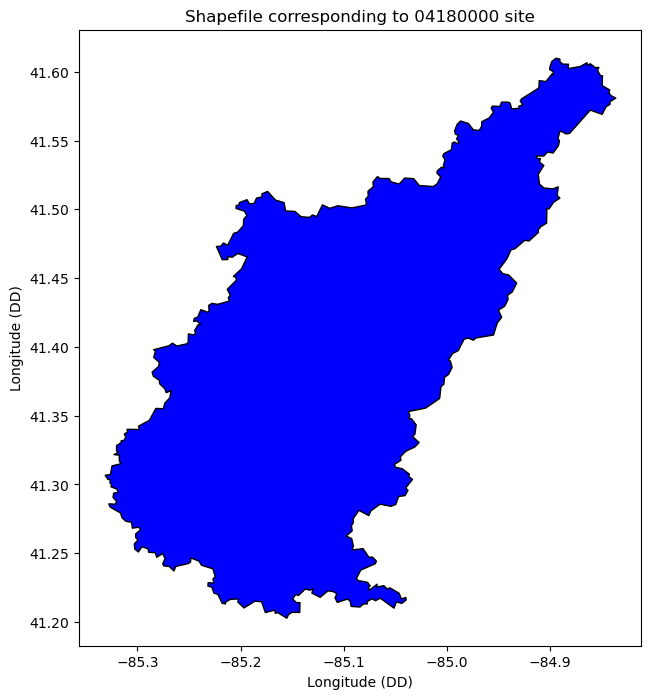

In [10]:
## Get the watershed using USGS station number using pynhd module
## WRITE THE CODE BELOW


## Plot the watershed
## DD indicates latitude/ longitude degrees is followed by immediately followed by decimal
ax = watershed.plot(facecolor="b", 
                    edgecolor="k", 
                    figsize=(8, 8))
plt.title(f"Shapefile corresponding to {site_id} site")
plt.xlabel("Longitude (DD)")
plt.ylabel("Longitude (DD)")

## Saving the watershed file as a shapefile at desired location
## WRITE THE CODE BELOW





## <span style="color:green">Step 2: Get the extents for downloading DEM</span>

<ul>
<li> Extents of the basin (watershed) is obtained using .total_bounds </li>
<li> Then we will find the bounding extents using math floor and ceil function </li>
    

In [11]:
## Get the min and max of latitude and longitude (or easting and northing)
extents_basin=watershed.total_bounds

## N or S and W or E may become a problem
print(f'Left Bounding Longtitude is {extents_basin[0]:.3f}\u00b0 or {abs(extents_basin[0]):.3f}\u00b0 W')
print(f'Right Bounding Longtitude is {extents_basin[2]:.3f}\u00b0 or {abs(extents_basin[2]):.3f}\u00b0 W')
print(f'Bottom Bounding Latitude is {extents_basin[1]:.3f}\u00b0 or {abs(extents_basin[1]):.3f}\u00b0 N')
print(f'Top Bounding Latitude is {extents_basin[3]:.3f}\u00b0 or {abs(extents_basin[3]):.3f}\u00b0 N')

Left Bounding Longtitude is -85.332° or 85.332° W
Right Bounding Longtitude is -84.837° or 84.837° W
Bottom Bounding Latitude is 41.203° or 41.203° N
Top Bounding Latitude is 41.610° or 41.610° N


In [12]:
## DEMs are numbered using integer
## Calculate largest integer that equals or not greater than left and bottom bounds
## WRITE THE CODE BELOW


## You may be tempted to calculate the ceil of right extent
## But, number scheme is such that 84W indicates data from -84 to -83 deg W

## Calculate smallest integer that equals or not less than right and upper bounds
## WRITE THE CODE BELOW



## Similarly, you may be tempted to calculate the floor of bottom extent
## But, number scheme is again such that 40N includes data from +39 to +40 deg N 

## Calulate the number of tiles to be downloaded from USGS
num_tiles_download=(((extent_left+1)-extent_right)*((extent_top+1)-extent_bottom))
print(f"Number of tiles to be downloaded: {num_tiles_download}")
print(f"Left: {extent_left}, Right: {extent_right}, Bottom: {extent_bottom}, Top: {extent_top}")

Number of tiles to be downloaded: 2
Left: 86, Right: 85, Bottom: 42, Top: 42


In [13]:
## Create a progress bar for monitoring the download process
class MyProgressBar():
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar=progressbar.ProgressBar(maxval=total_size)
            self.pbar.start()

        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(downloaded)
        else:
            self.pbar.finish()

## <span style="color:green">Step 3a: Downloading the DEM from USGS-Amazon Web Service</span>

<ul>
<li> Create a for loop anf download the DEM covering the shapefile </li>
<li> Save it in a folder </li>

In [33]:
current_filenum=1

for lon in (range(extent_right,extent_left+1,1)):
    for lat in (range(extent_bottom,extent_top+1,1)):
        usgs_filename=f'n{lat:02d}w{lon:03d}'
        
        print(f'Beginning file {current_filenum} download with urllib2  out of {num_tiles_download}...')
        url = (f'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/{resolution}/TIFF'
               f'/current/{usgs_filename}/USGS_{resolution}_{usgs_filename}.tif'
              )
                
        ## The r in 'fr' disables backslach escape sequence processing
        local_fileloc_filename=fr'{folder_input}/USGS_{resolution}_{usgs_filename}.tif'
        
        ## Retrieve the file using the weblink and local path with file name
        print('Data downloaded from : ')
        print(url)
        ## WRITE THE CODE BELOW
        #urllib.request.urlretrieve(url,local_fileloc_filename) #without progressbar for multiple USGS sites
        
        
        
        print(f'Completed file {current_filenum} download with urllib2 out of {num_tiles_download}...')
        print(f'*************************************************************************************\n')
        
        current_filenum+=1

Beginning file 1 download with urllib2  out of 2...
Data downloaded from : 
https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/current/n42w085/USGS_13_n42w085.tif


100% (418844626 of 418844626) |##########| Elapsed Time: 0:00:20 Time:  0:00:20


Completed file 1 download with urllib2 out of 2...
*************************************************************************************

Beginning file 2 download with urllib2  out of 2...
Data downloaded from : 
https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/current/n42w086/USGS_13_n42w086.tif


100% (429895986 of 429895986) |##########| Elapsed Time: 0:00:23 Time:  0:00:23


Completed file 2 download with urllib2 out of 2...
*************************************************************************************



## <span style="color:green">Step 3b: Plotting the downloaded (unmerged) DEMs along with watershed shapefile</span>

<ul>
<li> Plot the different DEMs using rasterio package </li>
<li> Also, plot the shapefile of the watershed </li>

Text(53.722222222222214, 0.5, 'Longitude (DD)')

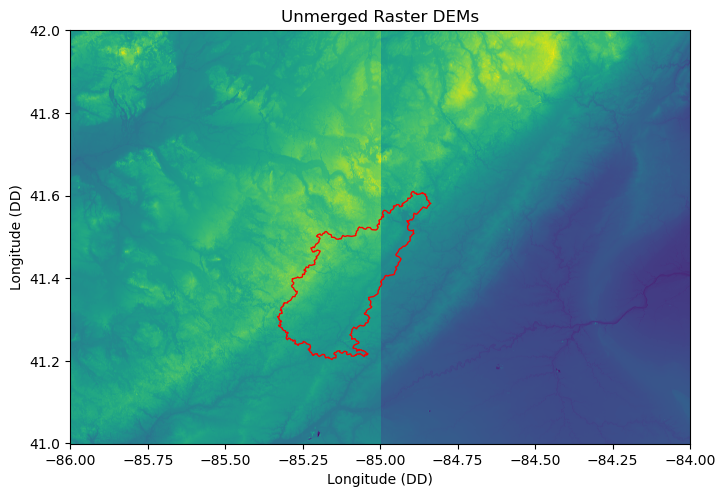

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))

for lon in range(extent_right,extent_left+1,1):
    for lat in range(extent_bottom,extent_top+1,1):
        usgs_filename=f'n{lat:02d}w{lon:03d}'
        ## WRITE THE CODE BELOW
        
        
        
        rasterio.plot.show(raster,
                           ax=ax,
                           cmap='viridis')
        #print(f'lat: {lat},lon: {lon},file:{local_fileloc_filename}')
watershed.plot(ax=ax, 
           facecolor='none', 
           edgecolor='red')
plt.title("Unmerged Raster DEMs")
plt.xlabel("Longitude (DD)")
plt.ylabel("Longitude (DD)")
